In [173]:
# making buffers ! - first use geometric, later base on transport distance?

# First, load packages
import pandas as pd
import os
import numpy as np
import shapely as sp

import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
# only for jupyter nb to show plots inline
%matplotlib inline 

#set wd
os.chdir("/Users/anayahall/projects/grapevine")

from scripts.fxns import epsg_meters

def epsg_meters(gdf, proj=3310):
    g = gdf.copy()
    g = g.to_crs(epsg=proj)
    return g

In [188]:
### LOAD ALL DATA

# Load SWIS DATA
swis_proj =  gpd.read_file("data/clean/clean_swis.shp")

# LOAD COUNTY SHAPEFILE 
CA_proj = gpd.read_file("data/raw/CA_Counties/CA_Counties_TIGER2016.shp")
# print("Ca_proj crs: ", CA_proj.crs)
CA_proj.head()

# LOAD BIOMASS DATA
# waste_proj = gpd.read_file("data/clean/techbiomass_pts.shp")
waste_proj = gpd.read_file("data/clean/grossbiomass_pts.shp")

#CONVERT TO METERS!!
swis = epsg_meters(swis_proj)

swis.crs

# load census tract shapefile ? might use for elsewhere?
# CA = gpd.read_file("data/raw/tl_2018_06_tract/tl_2018_06_tract.shp")

{'init': 'epsg:3310', 'no_defs': True}

In [222]:
waste = pd.read_csv("data/raw/biomass.inventory.technical.csv")
waste.columns = ['County', 'Feedstock', 'BDTons', 'year', 'Category']
# waste.head()

ofmsw = waste[waste['Category'] == "organic fraction municipal solid waste"]
# ofmsw = msw[(msw['Feedstock'] == "FOOD") | (msw['Feedstock'] == "GREEN")]

fw_mc = 0.7
gw_mc = 0.5

fw = ofmsw[ofmsw['Feedstock'] == "FOOD"]
gw = ofmsw[ofmsw['Feedstock'] == "GREEN"]

fw['WetTons'] = fw['BDTons'] * (1 + fw_mc)
gw['WetTons'] = gw['BDTons'] * (1 + gw_mc)

ow = fw.append(gw)
ow

all_waste = waste.groupby(['County'])['BDTons'].sum()
all_waste.head()

/Users/anayahall/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/anayahall/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


County
Alameda      2.282809e+06
Alpine       3.010265e+05
Amador       9.384114e+05
Butte        2.342253e+06
Calaveras    1.605504e+06
Name: BDTons, dtype: float64

In [176]:
# df.loc[df['product']=='a', ['market_penetration_rate', 'success_rate']] * 100
# ofmsw.loc[ofmsw[['Feedstock']] == "FOOD", [['BDTons']]] *= (1 + fw_mc)
# of2.head()

In [177]:
ow_sum = ow.groupby(['County'], as_index = False)['WetTons'].sum()
ow_sum.head(10)
# msw['biomass.feedstock'].value_counts()
#subset to just food
# foodwaste = waste[(waste['biomass.feedstock'] == "FOOD") & (waste['year'] == 2014)]

,County,WetTons
0,Alameda,614940.261446
1,Alpine,690.464297
2,Amador,13625.438116
3,Butte,94274.440388
4,Calaveras,16364.637787
5,Colusa,11138.509552
6,Contra Costa,384663.552963
7,Del Norte,8353.145000
8,El Dorado,72235.949355
9,Fresno,417632.859344


In [178]:
CA = epsg_meters(CA_proj)
# CA.crs

In [190]:
swis = epsg_meters(swis_proj)
swis.crs


{'init': 'epsg:3310', 'no_defs': True}

In [180]:
# add buffers - should be in meters now.....
swis['buffers'] = swis.buffer(15000)
# one degree is about 85km 

# gdf.set_geometry('buffers').plot()

In [181]:
# f, ax = plt.subplots(1)
# CA.plot(ax = ax, cmap='Set3', linewidth=0.1)
# swis.set_geometry('buffers').plot(ax = ax, color="blue", alpha="0.1")
# swis.set_geometry('geometry').plot(ax = ax, color="black", marker = '*', markersize= 1)
# ax.axis('off')
# ax.set_title('Composting Permits in CA', fontdict={'fontsize': '12', 'fontweight' : '3'})
# plt.savefig("maps/CAwbuffers.png", dpi=300)

In [182]:
# attempt to nest plotting
# swis.plot(ax=CA.plot(cmap='Set3', figsize=(10, 6)), marker='o', markersize=15)
# ax.axis('off')
# ax.set_title('Composting Permits in CA', fontdict={'fontsize': '12', 'fontweight' : '3'})
# plt.savefig("maps/map_export.png", dpi=300)

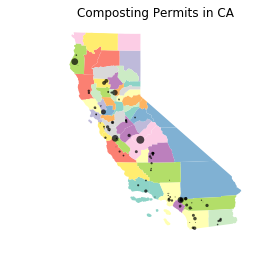

In [183]:
# better plot, with title
f, ax = plt.subplots(1)
CA.plot(ax = ax, cmap='Set3', figsize = (10,6), linewidth=0.1)
swis.plot(ax = ax, markersize = swis.cap_m3/10000, marker = 'o', color = 'black', alpha=.7, linewidth=0)
ax.axis('off')
ax.set_title('Composting Permits in CA', fontdict={'fontsize': '12', 'fontweight' : '3'})
plt.savefig("maps/FacilitiesbyCapacity.png", dpi=300)

In [191]:
# make gdf for plotting capacity by county 
CA["County"] = CA["NAME"]
swis_joined = pd.merge(swis, CA, on = "County")

# turn capacity from cubic meters into tons --> m3 * (1yd3/0.765m3) * (0.386ton/m3)
swis_joined['cap_tons'] = swis_joined['cap_m3'] * (1/0.765) * (0.386)
swis_joined.head()

# #sum capacity by county
swis_grouped = pd.DataFrame(swis_joined.groupby(['County'], as_index = False)['cap_tons'].sum())
# remerge with CA shapefile data
capmap = pd.merge(CA, swis_grouped, on = "County")
capmap.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,County,cap_tons
0,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,(POLYGON ((-53692.14841964634 -435068.90484861...,Santa Barbara,91857.767296
1,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,(POLYGON ((33908.12392894991 -526703.193930760...,Ventura,6481.027796
2,06,037,00277283,06037,Los Angeles,Los Angeles County,06,H1,G4020,348,31080,31084,A,10510651024,1794730436,+34.1963983,-118.2618616,(POLYGON ((123902.3558812202 -503236.488604530...,Los Angeles,143672.041424
3,06,097,01657246,06097,Sonoma,Sonoma County,06,H1,G4020,488,42220,None,A,4081437574,497508807,+38.5251824,-122.9261095,POLYGON ((-256278.6441238033 37049.10538577149...,Sonoma,38209.424026
4,06,073,00277301,06073,San Diego,San Diego County,06,H1,G4020,None,41740,None,A,10895149811,826195031,+33.0236041,-116.7761174,POLYGON ((239171.2658717657 -533898.4040978756...,San Diego,210960.540966


In [185]:
# foodwaste["County"] = foodwaste["COUNTY"]
# ow.rename(columns={'COUNTY':'County'}, 
#                  inplace=True)
# ow_sum.head()
owmap = pd.merge(CA, ow_sum, on = "County")
owmap.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,County,WetTons
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,POLYGON ((-56192.57028813594 186608.4199908176...,Sierra,1339.660509
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-103238.272692511 78232.45042174123,...",Sacramento,636621.532077
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,(POLYGON ((-53692.14841964634 -435068.90484861...,Santa Barbara,187819.410078
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,POLYGON ((-55079.94444234047 36283.02501270594...,Calaveras,16364.637787
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,(POLYGON ((33908.12392894991 -526703.193930760...,Ventura,420993.324626


In [186]:
# ow.sort_values(by=['disposal.yields'])

In [187]:
# swis.crs
# capmap.crs
# CA.crs
# swis[swis['County'] == "San Bernardino"]

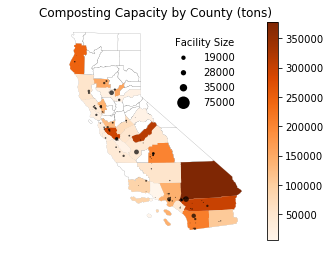

In [192]:
#### PLOT CAPACITY BY COUNTY #####
plotvar = capmap['cap_tons']

# before plotting prep legend
c = []
for i in [10, 25, 50, 75]:
    c.append(int(round(np.percentile(plotvar, i), -3)))

# Map Capacity by County
f, ax = plt.subplots(1)
CA.plot(ax = ax, color = "white", figsize = (10,10), linewidth=0.1, edgecolor = "black")
capmap.plot(ax = ax, column = plotvar, cmap = "Oranges", legend = True)
swis.set_geometry('geometry').plot(ax = ax, markersize = swis_joined.cap_tons/10000, marker = 'o', 
                                  legend = True, color = 'black', alpha=.7, linewidth=0)
ax.axis('off')
ax.set_title('Composting Capacity by County (tons)', fontdict={'fontsize': '12', 'fontweight' : '3'})

l1 = plt.scatter([],[], s=c[0]/1000, edgecolors='none', color = "black")
l2 = plt.scatter([],[], s=c[1]/1000, edgecolors='none', color = "black")
l3 = plt.scatter([],[], s=c[2]/1000, edgecolors='none', color = "black")
l4 = plt.scatter([],[], s=c[3]/1000, edgecolors='none', color = "black")

labels = [str(c[0]), str(c[1]), str(c[2]), str(c[3])]
labels = [str(c[0]), str(c[1]), "35000", "75000"]

leg = plt.legend([l1, l2, l3, l4], labels, ncol = 1, frameon=False, fontsize=10,
handlelength=2, loc = 1, borderpad = 1,
handletextpad=1, title='Facility Size', scatterpoints = 1)


plt.savefig("maps/CapacitybyCounty.png", dpi=300)

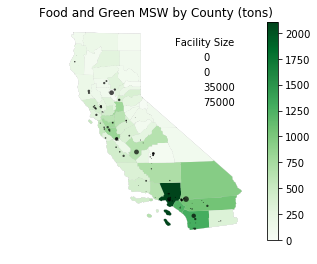

In [196]:
#### PLOT ORGANIC WASTE GENERATION BY COUNTY #####
plotvar = np.sqrt(owmap['WetTons'])
# column.sort_values()
# owmap['disposal.yields']

markervar= swis_joined.cap_tons/10000

c = []
for i in [10, 25, 50, 75]:
    c.append(int(round(np.percentile(markervar, i), -3)))

f, ax = plt.subplots()
CA.plot(ax = ax, color = "white", figsize = (10,10), linewidth=0.1, edgecolor = "black")
owplot = owmap.plot(ax = ax, column = plotvar, cmap = "Greens", legend = True)
swis.set_geometry('geometry').plot(ax = ax, markersize = markervar, marker = 'o', 
                                  legend = True, color = 'black', alpha=.7, linewidth=0)
# plt.colorbar(label="waste")
ax.axis('off')
ax.set_title('Food and Green MSW by County (tons)', fontdict={'fontsize': '12', 'fontweight' : '3'})

l1 = plt.scatter([],[], s=c[0]/1000, edgecolors='none', color = "black")
l2 = plt.scatter([],[], s=c[1]/1000, edgecolors='none', color = "black")
l3 = plt.scatter([],[], s=c[2]/1000, edgecolors='none', color = "black")
l4 = plt.scatter([],[], s=c[3]/1000, edgecolors='none', color = "black")

labels = [str(c[0]), str(c[1]), str(c[2]), str(c[3])]
labels = [str(c[0]), str(c[1]), "35000", "75000"]

leg = plt.legend([l1, l2, l3, l4], labels, ncol = 1, frameon=False, fontsize=10,
handlelength=2, loc = 1, borderpad = 1,
handletextpad=1, title='Facility Size', scatterpoints = 1)

plt.savefig("maps/OWbyCounty.png", dpi=300)

In [166]:
# disposal = dict(zip(ow['County'], ow['disposal.yields']))
# capacity = dict(zip(swis['County'], swis['cap_m3']))
# disposal = pd.DataFrame(ow['County'], ow['BDTons'])

In [230]:
merged = pd.merge(owmap, swis_grouped, on = "County" )


# feck = pd.merge(pd.DataFrame(all_waste, index=False), swis_grouped, on="County")

merged['excess'] = (merged['WetTons']) - merged['cap_tons']

# merged.sort_values(['excess']).head()
merged['excess'].tail()

26      7236.002830
27    -21603.425987
28    268108.255477
29     61501.884593
30   -142949.015540
Name: excess, dtype: float64

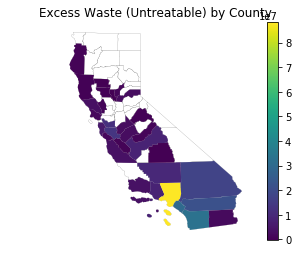

In [228]:
### PLOT DIFFERENCE BETWEEN GENERATION AND CAPACITY ####

## redo as bubbles with color for poverty??

plotvar = merged['excess']# * (1/100) 
# plotvar = np.sqrt(merged['excess'])
# plotvar = np.log(merged['excess'])

f, ax = plt.subplots(1)
CA.plot(ax = ax, color = "white", figsize = (10,10), linewidth=0.1, edgecolor = "black")
merged.plot(ax = ax, column = plotvar, cmap = "viridis", legend = True)
# swis.set_geometry('geometry').plot(ax = ax, markersize = swis.cap_m3/10000, marker = 'o', 
#                                   legend = True, color = 'black', alpha=.7, linewidth=0)
ax.axis('off')
ax.set_title('Excess Waste (Untreatable) by County', fontdict={'fontsize': '12', 'fontweight' : '3'})


In [209]:
gl_wp = gpd.read_file("data/raw/CA_FMMP_G/gl_bycounty/grazingland_county.shp")
gl = epsg_meters(gl_wp)
gl.crs

gl.shape()

TypeError: 'tuple' object is not callable

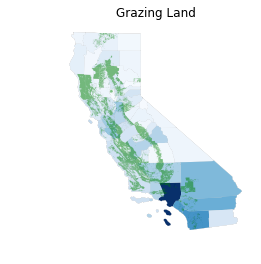

In [207]:
# owmap.head()

f, ax = plt.subplots()
CA.plot(ax = ax, color = "white", figsize = (10,10), linewidth=0.1, edgecolor = "black")
owmap.plot(ax = ax, column = np.sqrt(owmap.WetTons), cmap = "Blues", legend = False)
gl.plot(ax= ax, color = "green", alpha = .5)
ax.axis('off')
ax.set_title('Grazing Land', fontdict={'fontsize': '12', 'fontweight' : '3'})

plt.savefig("maps/grazingland.png", dpi=300)